In [1]:
# Common imports
import os
import sys
import re
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from numpy.random import seed

In [2]:
def get_data(path_to_data):
    if re.search('1st', path_to_data):
        nfeatures = 8
        column_names = ['Bearing 1a','Bearing 1b','Bearing 2a','Bearing 2b',
                        'Bearing 3a','Bearing 3b','Bearing 4a','Bearing 4b']
    else:
        nfeatures = 4
        column_names = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
    merged_data = pd.DataFrame()
    for filename in os.listdir(path_to_data):
        dataset=pd.read_csv(os.path.join(path_to_data, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean())
        dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,nfeatures))
        dataset_mean_abs.index = [filename]
        merged_data = merged_data.append(dataset_mean_abs)
    merged_data.columns = column_names
    merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
    merged_data = merged_data.sort_index()
    merged_data.to_csv('merged_{}.csv'%re.findall('\dst', path_to_data))
    return merged_data

In [3]:
#data_1test.plot(figsize = (12,6))

In [4]:
def split_data(data, train_fraction=0.5):
    split_index = str(data.index[int(len(data)*train_fraction)])
    X_train = data[:split_index]
    X_test = data[split_index:]
    
    scaler = preprocessing.MinMaxScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                                  columns=X_train.columns, 
                                  index=X_train.index)

    X_train.sample(frac=1)

    X_test = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns, 
                                 index=X_test.index)
    return X_train, X_test

In [5]:
class DenseAE(nn.Module):
    def __init__(self, features_dim, inner_dim):
        super(DenseAE, self).__init__()
        intermediate = (features_dim + inner_dim)//2
        self.input = nn.Linear(features_dim, intermediate)
        self.h1 = nn.Linear(intermediate, inner_dim)
        self.h1_inv = nn.Linear(inner_dim, intermediate)
        self.output = nn.Linear(intermediate, features_dim)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
    def encode(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.h1(x))
        return x
    
    def decode(self, x):
        x = torch.relu(self.h1_inv(x))
        x = self.output(x)
        return x
    
def fetch_batch(data, batch_size):
    n_batches = int(np.ceil(len(data)/batch_size))
    for j in range(n_batches):
        start = j*batch_size
        end = start + batch_size
        yield data[start:end]

def autoencoder_training(net, optimizer, criterion, data, n_epoches, batch_size):
    train_losses = []
    for i in range(1, n_epoches+1):
        batch_losses= []
        for bi, batch in enumerate(fetch_batch(data, batch_size)):
            batch = Variable(torch.from_numpy(batch))
            optimizer.zero_grad()
            outputs = net(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.sum(batch_losses)/len(data))
        if i%20 == 0 or i == n_epoches:
            print('\rEpoch: %2d train loss: %.5f'
                             %(i, train_losses[-1]))
    return net, train_losses

In [41]:
def train_on_data(data):
    FEATURES_DIM = data.shape[1]
    INNER_DIM = FEATURES_DIM//2
    net = DenseAE(FEATURES_DIM, INNER_DIM)
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    net_trained, train_losses = autoencoder_training(net=net, optimizer=optimizer, criterion=criterion,
                                                     data=np.matrix(data).astype(np.float32), 
                                                     n_epoches=70, batch_size=1000)
    return net_trained, train_losses

def test_on_data(data, trained_net):
    loss = nn.MSELoss()
    loss_values = []
    for i in range(data.shape[0]):
        record = Variable(torch.from_numpy(np.matrix(data)[i,:].astype(np.float32)))
        record_reconstruct = trained_net( record )
        loss_value = loss(record_reconstruct, record)
        loss_values.append(loss_value)
    return loss_values

def plot_training(train_losses, threshold):
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_losses)+1), train_losses)
    plt.xlabel('Epoches')
    plt.ylabel('Loss [observation]')

    plt.subplot(1,2,2)
    plt.axvline(threshold, linestyle='--', color='r')
    plt.hist(train_losses, bins=30)
    plt.xlabel('Loss')
    plt.ylabel('Loss [counts]')
    plt.show()

def plot_losses(time, losses, threshold):
    plt.plot(time, np.log(losses))
    plt.axhline(threshold, linestyle='--', color='r')
    plt.xlabel('Time')
    plt.ylabel('Loss (log)')
    plt.show()

In [7]:
data_2test = get_data(path_to_data='IMS/2nd_test/')

data_2test_train, data_2test_test = split_data(data_2test, train_fraction=0.3)

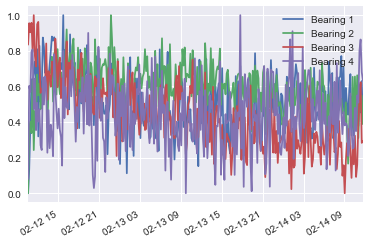

In [39]:
data_2test_train.plot()

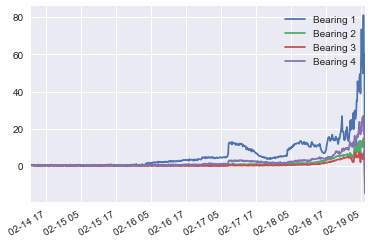

In [40]:
data_2test_test.plot()

Epoch: 20 train loss: 0.00013
Epoch: 40 train loss: 0.00010
Epoch: 60 train loss: 0.00010
Epoch: 70 train loss: 0.00010


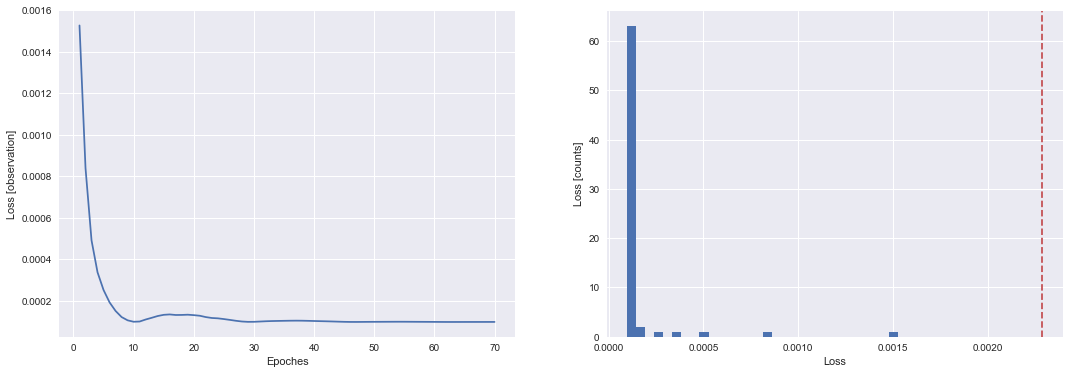

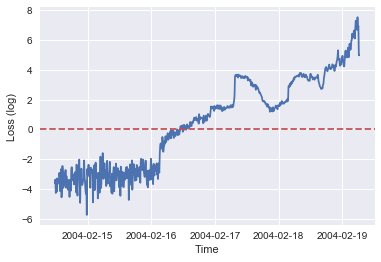

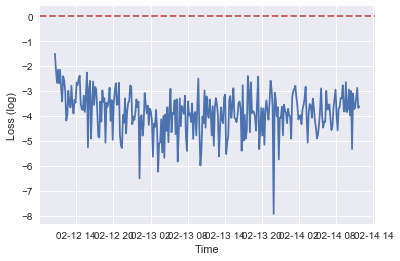

In [43]:
trained_net, train_losses2 = train_on_data(data_2test_train)
loss_values_train = test_on_data(data_2test_train, trained_net)
loss_values_test = test_on_data(data_2test_test, trained_net)
threshold2 = 1.5*np.max(train_losses2)

plot_training(train_losses2, threshold2)
plot_losses(data_2test_test.index, loss_values_test, threshold2)
plot_losses(data_2test_train.index, loss_values_train, threshold2)

In [9]:
data_1test = get_data(path_to_data='IMS/1st_test/')

data_1test_train, data_1test_test = split_data(data_1test, train_fraction=0.3)

Epoch: 20 train loss: 0.00014
Epoch: 40 train loss: 0.00013
Epoch: 60 train loss: 0.00013
Epoch: 70 train loss: 0.00013


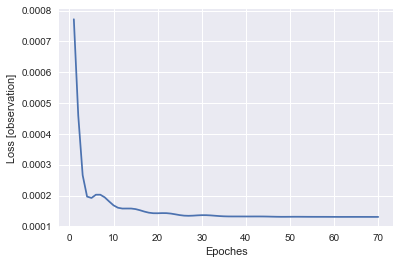

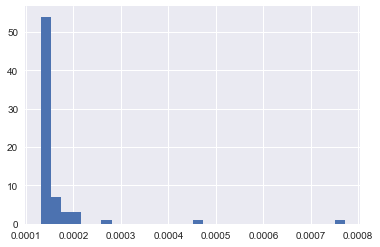

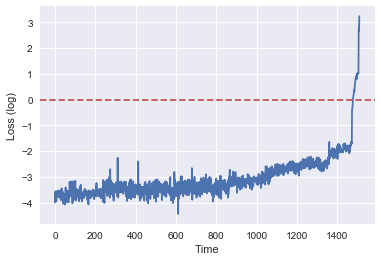

In [10]:
trained_net, threshold1 = train_on_data(data_1test_train)
loss_values_test = test_on_data(data_1test_test, trained_net)

plt.plot(np.log(loss_values_test))
plt.axhline(threshold2, linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('Loss (log)')
plt.show()

In [11]:
data_3test = get_data(path_to_data='IMS/3rd_test/')

In [12]:
data_3test_train, data_3test_test = split_data(data_3test, train_fraction=0.5)

Epoch: 20 train loss: 0.00002
Epoch: 40 train loss: 0.00002
Epoch: 60 train loss: 0.00002
Epoch: 70 train loss: 0.00002


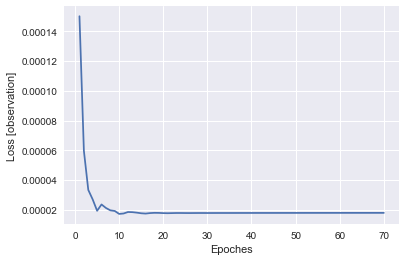

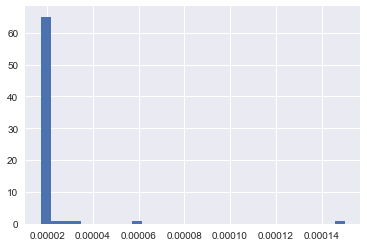

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


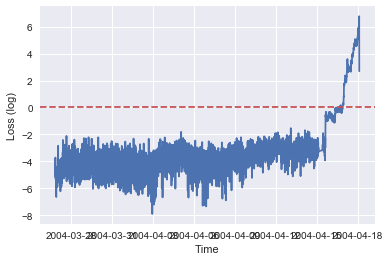

In [13]:
trained_net, threshold3 = train_on_data(data_3test_train)
loss_values_test = test_on_data(data_3test_test, trained_net)

plt.plot(data_3test_test.index, np.log(loss_values_test))
plt.axhline(threshold2, linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('Loss (log)')
plt.show()